## Importing the relevant libraries

In [120]:
import torch, time
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
if torch.cuda.is_available():
    device = torch.cuda.get_device_name()
    print(device)

Tesla T4


## Loading the dataset

In [122]:
df = pd.read_csv("/kaggle/input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv",parse_dates=True,index_col='date_time',usecols=['date_time','traffic_volume'])
df.head()

,traffic_volume
date_time,
2012-10-02 09:00:00,5545
2012-10-02 10:00:00,4516
2012-10-02 11:00:00,4767
2012-10-02 12:00:00,5026
2012-10-02 13:00:00,4918


## Data Exploration

In [123]:
df.shape

(48204, 1)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   traffic_volume  48204 non-null  int64
dtypes: int64(1)
memory usage: 753.2 KB


In [125]:
df.isna().sum()

traffic_volume    0
dtype: int64

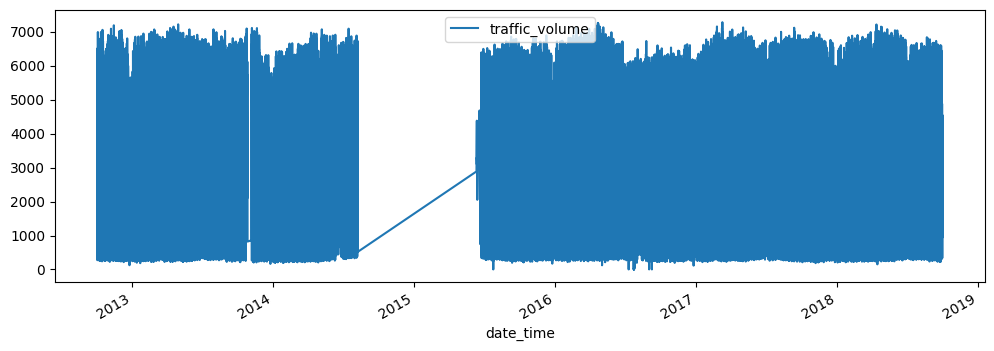

In [126]:
df.plot(figsize=(12,4));

## Feature Engineering

In [127]:
y = df.traffic_volume.astype(float).values    
y

array([5545., 4516., 4767., ..., 2159., 1450.,  954.])

In [128]:
y.shape

(48204,)

In [129]:
test_size = 32
train_set = y[:-test_size]
test_set = y[-test_size:]

In [130]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_data = scaler.fit_transform(train_set.reshape(-1,1))

In [131]:
train_data = torch.FloatTensor(train_data).view(-1)
train_data

tensor([0.5234, 0.2407, 0.3096,  ..., 0.3008, 0.3401, 0.2552])

In [132]:
def input_data(sequence,window_size):
    output = []
    L = len(sequence)
    
    for i in range(L-window_size):
        window = sequence[i:i+window_size]
        label = sequence[i+window_size:i+window_size+1]
        window = window.cuda()
        label = label.cuda()
        output.append((window,label))
    
    return output

In [133]:
train_df = input_data(train_data,window_size=12)
train_df[:5]

[(tensor([ 0.5234,  0.2407,  0.3096,  0.3808,  0.3511,  0.4234,  0.5341,  0.6525,
           0.5909,  0.3104, -0.0277, -0.2352], device='cuda:0'),
  tensor([-0.3514], device='cuda:0')),
 (tensor([ 0.2407,  0.3096,  0.3808,  0.3511,  0.4234,  0.5341,  0.6525,  0.5909,
           0.3104, -0.0277, -0.2352, -0.3514], device='cuda:0'),
  tensor([-0.5799], device='cuda:0')),
 (tensor([ 0.3096,  0.3808,  0.3511,  0.4234,  0.5341,  0.6525,  0.5909,  0.3104,
          -0.0277, -0.2352, -0.3514, -0.5799], device='cuda:0'),
  tensor([-0.7354], device='cuda:0')),
 (tensor([ 0.3808,  0.3511,  0.4234,  0.5341,  0.6525,  0.5909,  0.3104, -0.0277,
          -0.2352, -0.3514, -0.5799, -0.7354], device='cuda:0'),
  tensor([-0.8610], device='cuda:0')),
 (tensor([ 0.3511,  0.4234,  0.5341,  0.6525,  0.5909,  0.3104, -0.0277, -0.2352,
          -0.3514, -0.5799, -0.7354, -0.8610], device='cuda:0'),
  tensor([-0.9118], device='cuda:0'))]

In [134]:
len(train_df) # len(sequence) - window_size - test_size

48160

## Model Training & Evaluation

### Training

In [135]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,output_size)
        self.hidden_states = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_output, self.hidden_states = self.lstm(seq.view(len(seq),1,-1),self.hidden_states)
        pred = self.linear(lstm_output.view(len(lstm_output),-1))
        return pred[-1]

In [136]:
torch.manual_seed(42)
model = LSTM().cuda()
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [137]:
total_params = 0

for param in model.parameters():
    total_params += param.numel()

print("Total parameters of LSTM model:", total_params)

Total parameters of LSTM model: 41301


In [138]:
next(model.parameters()).is_cuda

True

In [139]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [140]:
start_time = time.time()

epochs = 25

losses = []

for i in range(epochs):
    
    for seq, y_train in train_df:
        optimizer.zero_grad()
        model.hidden_states = (torch.zeros(1,1,model.hidden_size,device='cuda'),torch.zeros(1,1,model.hidden_size,device='cuda'))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {i+1} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.00430898554623127
Epoch 2 -> Loss: 0.0031234482303261757
Epoch 3 -> Loss: 0.0015858520055189729
Epoch 4 -> Loss: 0.0012699845246970654
Epoch 5 -> Loss: 0.0013393217232078314
Epoch 6 -> Loss: 0.0015095894923433661
Epoch 7 -> Loss: 0.002183713484555483
Epoch 8 -> Loss: 0.0027253117877990007
Epoch 9 -> Loss: 0.0027246957179158926
Epoch 10 -> Loss: 0.0024984010960906744
Epoch 11 -> Loss: 0.0023665581829845905
Epoch 12 -> Loss: 0.002247406868264079
Epoch 13 -> Loss: 0.002141335979104042
Epoch 14 -> Loss: 0.001342259463854134
Epoch 15 -> Loss: 0.0013643131824210286
Epoch 16 -> Loss: 0.0012040863512083888
Epoch 17 -> Loss: 0.0008512840140610933
Epoch 18 -> Loss: 0.0010331971570849419
Epoch 19 -> Loss: 0.0008362678345292807
Epoch 20 -> Loss: 0.0011199021246284246
Epoch 21 -> Loss: 0.0010385628556832671
Epoch 22 -> Loss: 0.0009398969123139977
Epoch 23 -> Loss: 0.0007027595420368016
Epoch 24 -> Loss: 0.0007248495821841061
Epoch 25 -> Loss: 0.0007957729394547641
Total time elap

### Evaluation

In [141]:
forecast = 32
window_size = 12

predictions = train_data[-window_size:].tolist()

model.eval()

for i in range(forecast):
    seq = torch.FloatTensor(predictions[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden_states = (torch.zeros(1,1,model.hidden_size,device='cuda'),torch.zeros(1,1,model.hidden_size,device='cuda'))
        predictions.append(model(seq).item())

In [142]:
predictions[-12:]

[0.2753612995147705,
 0.27921396493911743,
 0.28077369928359985,
 0.2641792297363281,
 0.2282836139202118,
 0.16334690153598785,
 0.04816904664039612,
 -0.06925244629383087,
 -0.1518210917711258,
 -0.24410663545131683,
 -0.3638553023338318,
 -0.5207531452178955]

In [143]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions

array([[2035.99998713],
       [3073.00000668],
       [3725.00000171],
       [4059.00000215],
       [4378.00001025],
       [4657.00002074],
       [4553.00002694],
       [4617.99999595],
       [4564.00005341],
       [4734.99996185],
       [4877.99998045],
       [4569.00002599],
       [4219.90325511],
       [3796.242553  ],
       [3423.05894494],
       [3105.65300286],
       [2750.07165015],
       [2295.32424688],
       [1721.95037603],
       [1158.71899366],
       [ 797.23652124],
       [ 563.09014082],
       [ 413.94470453],
       [ 380.42880058],
       [ 497.75041103],
       [ 907.0491147 ],
       [1735.98470926],
       [2705.28012514],
       [3609.78815302],
       [4136.65692806],
       [4469.22355592],
       [4642.07083225],
       [4642.31513023],
       [4656.33883238],
       [4662.01626539],
       [4601.61239624],
       [4470.95235467],
       [4234.58272159],
       [3815.33532977],
       [3387.92109549],
       [3087.37122595],
       [2751.451

In [144]:
df.index

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=48204, freq=None)

In [145]:
x = np.arange('2018-08-29','2018-09-30',dtype='datetime64')
x

array(['2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
       '2018-09-02', '2018-09-03', '2018-09-04', '2018-09-05',
       '2018-09-06', '2018-09-07', '2018-09-08', '2018-09-09',
       '2018-09-10', '2018-09-11', '2018-09-12', '2018-09-13',
       '2018-09-14', '2018-09-15', '2018-09-16', '2018-09-17',
       '2018-09-18', '2018-09-19', '2018-09-20', '2018-09-21',
       '2018-09-22', '2018-09-23', '2018-09-24', '2018-09-25',
       '2018-09-26', '2018-09-27', '2018-09-28', '2018-09-29'],
      dtype='datetime64[D]')

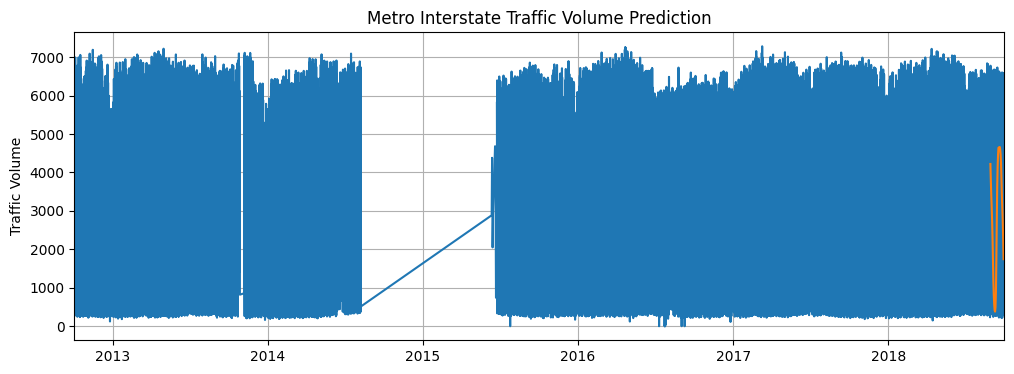

In [146]:
plt.figure(figsize=(12,4))
plt.title('Metro Interstate Traffic Volume Prediction')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['traffic_volume'])
plt.plot(x,predictions[-32:])
plt.show();

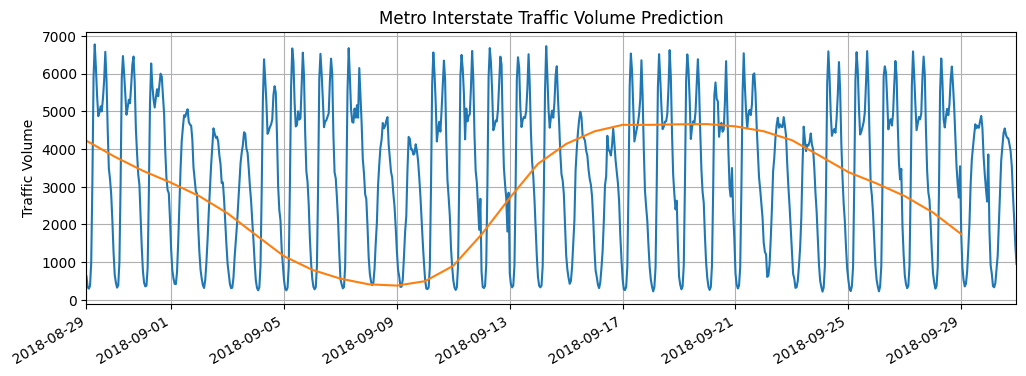

In [147]:
fig = plt.figure(figsize=(12,4))
plt.title('Metro Interstate Traffic Volume Prediction')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['traffic_volume']['2018-08-29':])
plt.plot(x,predictions[-32:])
plt.show();

In [148]:
y_norm = scaler.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)
all_data[:5]

[(tensor([ 0.5234,  0.2407,  0.3096,  0.3808,  0.3511,  0.4234,  0.5341,  0.6525,
           0.5909,  0.3104, -0.0277, -0.2352], device='cuda:0'),
  tensor([-0.3514], device='cuda:0')),
 (tensor([ 0.2407,  0.3096,  0.3808,  0.3511,  0.4234,  0.5341,  0.6525,  0.5909,
           0.3104, -0.0277, -0.2352, -0.3514], device='cuda:0'),
  tensor([-0.5799], device='cuda:0')),
 (tensor([ 0.3096,  0.3808,  0.3511,  0.4234,  0.5341,  0.6525,  0.5909,  0.3104,
          -0.0277, -0.2352, -0.3514, -0.5799], device='cuda:0'),
  tensor([-0.7354], device='cuda:0')),
 (tensor([ 0.3808,  0.3511,  0.4234,  0.5341,  0.6525,  0.5909,  0.3104, -0.0277,
          -0.2352, -0.3514, -0.5799, -0.7354], device='cuda:0'),
  tensor([-0.8610], device='cuda:0')),
 (tensor([ 0.3511,  0.4234,  0.5341,  0.6525,  0.5909,  0.3104, -0.0277, -0.2352,
          -0.3514, -0.5799, -0.7354, -0.8610], device='cuda:0'),
  tensor([-0.9118], device='cuda:0'))]

In [149]:
start_time = time.time()

epochs = 10
losses = []

model.train() # Set model to training phase to train on entire data

for i in range(1,epochs+1):
    
    for seq, y_train in all_data:
        optimizer.zero_grad()
        model.hidden_states = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                              torch.zeros(1,1,model.hidden_size,device='cuda'))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training on whole data: {(time.time() - start_time)/60} minutes.")

Epoch 1 -> Loss: 1.9338683614478214e-06
Epoch 2 -> Loss: 1.956479763975949e-06
Epoch 3 -> Loss: 0.0001359009329462424
Epoch 4 -> Loss: 0.00015484620234929025
Epoch 5 -> Loss: 1.2283294381632004e-05
Epoch 6 -> Loss: 1.288611997551925e-06
Epoch 7 -> Loss: 3.125033981632441e-05
Epoch 8 -> Loss: 5.167989058918465e-08
Epoch 9 -> Loss: 3.2464096875628456e-05
Epoch 10 -> Loss: 0.00020680091984104365
Total time elapsed in LSTM model training on whole data: 15.39881301720937 minutes.


In [151]:
# Forecast into unknown future
forecast = 32
window_size = 12
L = len(y)

predictions = y_norm[-window_size:].tolist()

model.eval() # Set model to evaluation phase

for i in range(forecast):
    seq = torch.FloatTensor(predictions[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden_states = (torch.zeros(1,1,model.hidden_size,device='cuda'),
                              torch.zeros(1,1,model.hidden_size,device='cuda'))
        pred = model(seq)
        predictions.append(pred.item())

In [152]:
predictions

[0.2032967060804367,
 0.2032967060804367,
 0.18186813592910767,
 0.18186813592910767,
 0.17664834856987,
 0.13516484200954437,
 0.0843406617641449,
 -0.026648351922631264,
 -0.23598900437355042,
 -0.4068681299686432,
 -0.6016483306884766,
 -0.7379120588302612,
 -0.8250203728675842,
 -0.8871344327926636,
 -0.9056134223937988,
 -0.8711737990379333,
 -0.7403727173805237,
 -0.3405607342720032,
 0.3038474917411804,
 0.5612758994102478,
 0.4358702003955841,
 0.317986398935318,
 0.23292744159698486,
 0.28126591444015503,
 0.35327425599098206,
 0.36053550243377686,
 0.42241108417510986,
 0.5671501755714417,
 0.7300528883934021,
 0.5961373448371887,
 0.2941548824310303,
 0.022135145962238312,
 -0.10105838626623154,
 -0.17582833766937256,
 -0.3118646740913391,
 -0.47271326184272766,
 -0.6476328372955322,
 -0.7718851566314697,
 -0.8266522884368896,
 -0.8523733615875244,
 -0.8426088094711304,
 -0.7649410963058472,
 -0.6281770467758179,
 -0.41366901993751526]

In [153]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions[-32:]

array([[ 636.92584276],
       [ 410.83066463],
       [ 343.56714249],
       [ 468.9273715 ],
       [ 945.04330873],
       [2400.35892725],
       [4746.00486994],
       [5683.04427385],
       [5226.56752944],
       [4797.47049212],
       [4487.85588741],
       [4663.80792856],
       [4925.91829181],
       [4952.34922886],
       [5177.5763464 ],
       [5704.42663908],
       [6297.39251375],
       [5809.93993521],
       [4710.72377205],
       [3720.5719313 ],
       [3272.14747399],
       [2999.98485088],
       [2504.81258631],
       [1919.32372689],
       [1282.61647224],
       [ 830.33802986],
       [ 630.98567009],
       [ 537.36096382],
       [ 572.90393353],
       [ 855.61440945],
       [1353.43554974],
       [2134.24476743]])

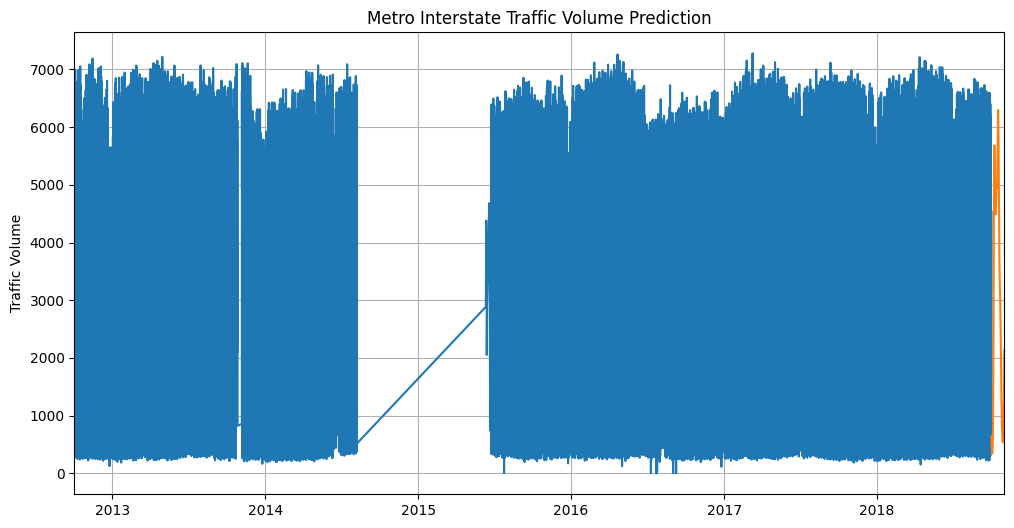

In [183]:
plt.figure(figsize=(12,6))
plt.title('Metro Interstate Traffic Volume Prediction')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['traffic_volume'])
plt.plot(x,true_predictions[-32:])
plt.show();

In [177]:
x = np.arange('2018-10-01','2018-11-02',dtype='datetime64')
x

array(['2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04',
       '2018-10-05', '2018-10-06', '2018-10-07', '2018-10-08',
       '2018-10-09', '2018-10-10', '2018-10-11', '2018-10-12',
       '2018-10-13', '2018-10-14', '2018-10-15', '2018-10-16',
       '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-20',
       '2018-10-21', '2018-10-22', '2018-10-23', '2018-10-24',
       '2018-10-25', '2018-10-26', '2018-10-27', '2018-10-28',
       '2018-10-29', '2018-10-30', '2018-10-31', '2018-11-01'],
      dtype='datetime64[D]')

In [178]:
len(x)

32

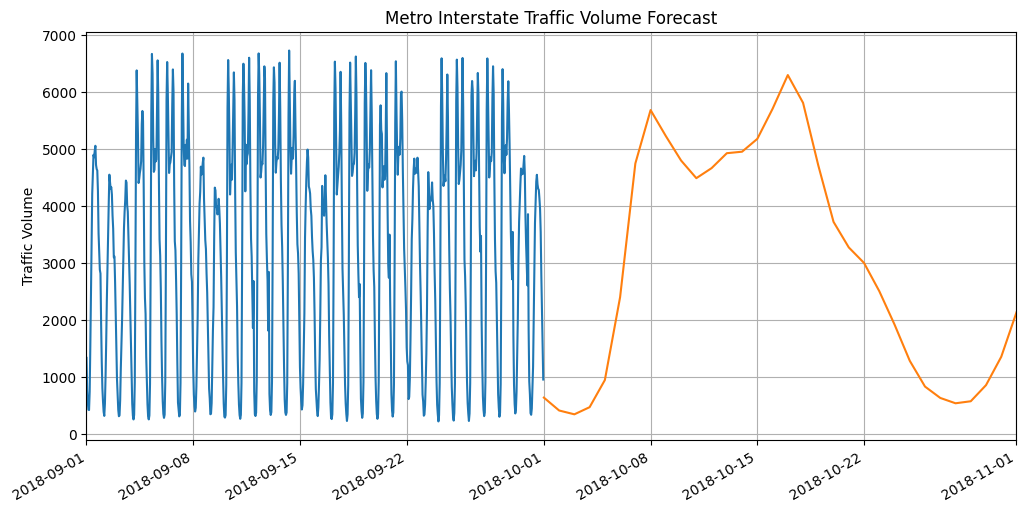

In [180]:
fig = plt.figure(figsize=(12,6))
plt.title('Metro Interstate Traffic Volume Forecast')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['traffic_volume']['2018-09-01':])
plt.plot(x,true_predictions[-32:])
plt.show();

In [181]:
torch.save(model,'metro_interstate_traffic_volume_forecaster.pt')